### Jupyter Notebook to compute morphological metrics from axon and myelin segmentation of a microscopy sample.

- To use it, you need the paths of the microscopy image and the segmentation prediction (output of AxonDeepSeg).


#### Imports

In [1]:
import numpy as np
import math
import os
import imageio
import matplotlib.pyplot as plt

from AxonDeepSeg.morphometrics.compute_morphometrics import *

%matplotlib inline

ImportError: cannot import name '_validate_lengths'

#### Read image and segmented prediction

In [2]:
# Change the image and segmentation paths here for your sample:
path_img = '/Users/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image.png'
path_pred = '/Users/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image_seg-axonmyelin.png'

In [3]:
# Read paths and compute axon/myelin masks
img = imageio.imread(path_img)
pred = imageio.imread(path_pred)
pred_axon = pred > 200
pred_myelin = np.logical_and(pred >= 50, pred <= 200)
path_folder, file_name = os.path.split(path_img)

FileNotFoundError: No such file: '/Users/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image.png'

### Step-by-step use case: extract morphometrics from a segmented microscopy sample

#### 1) Get axon morphometrics

In [4]:
# Compute axon morphometrics
stats_array = get_axon_morphometrics(pred_axon,path_folder)

NameError: name 'get_axon_morphometrics' is not defined

#### 2) Save axon morphometrics and load back

In [5]:
save_axon_morphometrics(path_folder,stats_array)
stats_array = load_axon_morphometrics(path_folder)

NameError: name 'save_axon_morphometrics' is not defined

#### 3) Extract and plot axon diameter distribution

In [6]:
# Get axon diameter distribution
axon_diam_list = [d['axon_diam'] for d in stats_array]

NameError: name 'stats_array' is not defined

In [7]:
# Plot histogram of axon diameter distribution
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(axon_diam_list,30, facecolor='g', alpha=0.7)
plt.xlabel('Axon equivalent diameter in um',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Axon diameter distribution',fontsize=11)
plt.grid(True)

NameError: name 'axon_diam_list' is not defined

<Figure size 576x432 with 0 Axes>

#### 4) Display boxplots of other axonal morphometrics (example with solidity and eccentricity)

In [20]:
# Get axon solidity distribution (measure of compactness of the axon)
axon_solidity_list = [d['solidity'] for d in stats_array]
# Get axon eccentricity distribution (measure of ellipticity/extent of the axon)
axon_eccentricity_list = [d['eccentricity'] for d in stats_array]

[Text(0,0,u'Solidity'), Text(0,0,u'Eccentricity')]

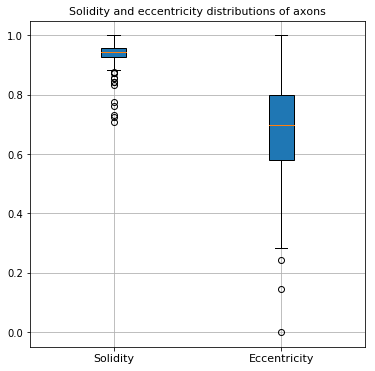

In [21]:
# Plot boxplots of solidity and eccentricity
plt.figure(figsize=(6,6))
data_to_plot = [axon_solidity_list,axon_eccentricity_list]
plt.boxplot(data_to_plot,patch_artist=True)
plt.title('Solidity and eccentricity distributions of axons',fontsize=11)
plt.grid(True)
frame1 = plt.gca()
frame1.set_xticklabels(['Solidity', 'Eccentricity'],fontsize=11)

#### 5) Display and save axon mask overlay labelled for axon diameter

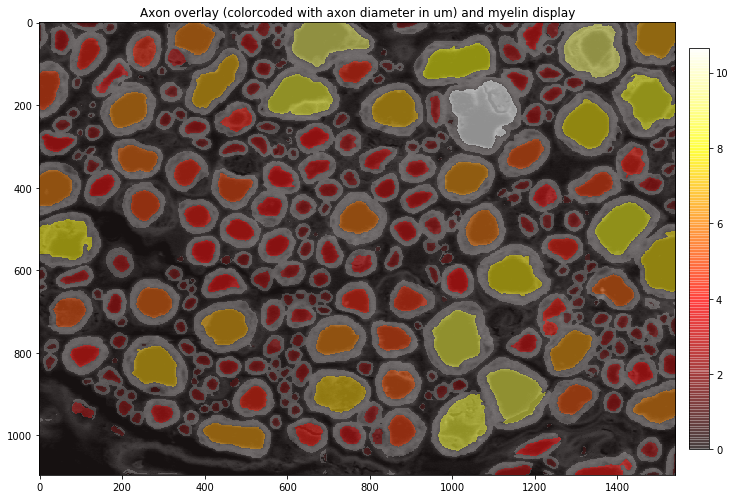

In [23]:
fig = display_axon_diameter(img,path_pred,pred_axon,pred_myelin)
from IPython.core.display import display
fig.canvas.draw()
display(fig)

#### 6) Compute aggregate axon/myelin morphometrics

In [13]:
# Compute aggregate metrics
aggregate_metrics = get_aggregate_morphometrics(pred_axon,pred_myelin,path_folder)
print(aggregate_metrics)

{'mean_axon_diam': 2.5575044164131997, 'mean_myelin_thickness': 0.5939360324353604, 'mvf': 0.3438579081741404, 'mean_myelin_diam': 3.7453764812839205, 'axon_density_mm2': 36008.66257253812, 'avf': 0.30040214667696113, 'gratio': 0.6828430811143673}


#### 7) Save aggregate metrics

In [14]:
write_aggregate_morphometrics(path_folder,aggregate_metrics)

#### Other useful code snippets

In [15]:
# Show metrics available for axons
print(stats_array[0].keys())

['axon_diam', 'solidity', 'eccentricity', 'y0', 'x0', 'orientation']


In [16]:
# Get axon diameter value of axon object 0
print(stats_array[0]['axon_diam'])

1.69958776035


In [17]:
# Get solidity value of axon object 50
print(stats_array[49]['solidity'])

0.9677523379554982


In [18]:
# Display all stats for axon object 10
print(stats_array[9])

{'axon_diam': 6.660677996480354, 'solidity': 0.9674829931972789, 'eccentricity': 0.4595592043543096, 'y0': 39.49430459850935, 'x0': 1491.883279426241, 'orientation': 0.2026448234414792}


In [19]:
# Get axon diameter value of all axons in list
axon_diam_list = [d['axon_diam'] for d in stats_array]

In [20]:
# Get number of axons in sample
print(np.size(axon_diam_list))

298


In [21]:
# Get mean diameter
mean_diam = np.mean(axon_diam_list)
print(mean_diam)

2.5575044164131997


In [22]:
# Get max diameter
max_diam = np.max(axon_diam_list)
print(max_diam)

10.661720314980407
